In [1]:
import os
from functools import wraps
from ase.optimize import BFGS
from ase.db import connect
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error 
import numpy as np
from ase.io.trajectory import Trajectory
from caxpert.src.utils.utils import timeit
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
from caxpert.src.tasks.inference import mk_inf_db, MLInfDataProcess
from scipy.spatial import Delaunay
import random
from ase.io import write
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

In [10]:
from ase.io.ulm import InvalidULMFileError
parent_p = 'relax_after_ml/'
for i in os.listdir(parent_p):
    relax_p = f'{parent_p}/{i}/relax.traj'
    if os.path.exists(relax_p):
        try:
            traj = Trajectory(relax_p)[-1]
            fmax = max(np.linalg.norm(traj.get_forces(), axis=1))
            if fmax >0.05:
                print(fmax, i, traj)
        except InvalidULMFileError:
            print(f'{i} has not finished.')
        

239 has not finished.
0.12508671548425232 650 Atoms(symbols='Ni28OCOCOCOCOCOC', pbc=[True, True, False], cell=[[2.4890158697766473, 0.0, 0.0], [8.711555544218266, 15.088856815544377, 0.0], [0.0, 0.0, 32.09681884264245]], initial_magmoms=..., tags=..., constraint=FixAtoms(indices=[0, 1, 4, 5, 8, 9, 12, 13, 16, 17, 20, 21, 24, 25]), calculator=SinglePointCalculator(...))
0.09136213902486504 6366 Atoms(symbols='Ni36OCOCOCOCOC', pbc=[True, True, False], cell=[[3.733523804664971, 2.1555509736491967, 0.0], [11.200571413994913, 19.399958762842772, 0.0], [0.0, 0.0, 32.09681884264245]], initial_magmoms=..., tags=..., constraint=FixAtoms(indices=[0, 1, 4, 5, 8, 9, 12, 13, 16, 17, 20, 21, 24, 25, 28, 29, 32, 33]), calculator=SinglePointCalculator(...))
0.14456745362556844 5979 Atoms(symbols='Ni36OC', pbc=[True, True, False], cell=[[3.733523804664971, 2.1555509736491967, 0.0], [11.200571413994913, 19.399958762842772, 0.0], [0.0, 0.0, 32.09681884264245]], initial_magmoms=..., tags=..., constraint=F

In [8]:
with connect('ft/ml_inf_dft_val.db') as db:
    for i in db.select():
        atoms = i.toatoms()
        print(i.key_value_pairs)
        # use for deleting entries, dont use it unless you know what you are doing
        # if len(i.key_value_pairs.keys()) == 1:
        #     del db[i.id]
        # print(atoms.get_chemical_formula(), atoms.get_potential_energy(), max(np.linalg.norm(atoms.get_forces(), axis=1)))

{'top_layer_atom_index': 3, 'co': 0.0, 'h': 0.625, 'original_id': 3605}
{'top_layer_atom_index': 3, 'co': 0.0, 'h': 0.333, 'original_id': 9404}
{'top_layer_atom_index': 3, 'co': 0.0, 'h': 0.4, 'original_id': 116}
{'top_layer_atom_index': 3, 'co': 0.0, 'h': 0.6, 'original_id': 97}
{'top_layer_atom_index': 3, 'co': 0.0, 'h': 0.875, 'original_id': 1865}
{'top_layer_atom_index': 3, 'co': 0.0, 'h': 0.25, 'original_id': 1900}
{'top_layer_atom_index': 3, 'co': 0.0, 'h': 0.571, 'original_id': 854}
{'top_layer_atom_index': 3, 'co': 0.0, 'h': 0.143, 'original_id': 772}
{'top_layer_atom_index': 3, 'co': 0.0, 'h': 0.714, 'original_id': 736}
{'top_layer_atom_index': 3, 'co': 0.0, 'h': 0.5, 'original_id': 381}
{'top_layer_atom_index': 3, 'co': 0.0, 'h': 1.0, 'original_id': 3}
{'top_layer_atom_index': 3, 'co': 0.875, 'h': 0.0, 'original_id': 1625}
{'top_layer_atom_index': 3, 'co': 0.111, 'h': 0.0, 'original_id': 5979}
{'top_layer_atom_index': 3, 'co': 0.5, 'h': 0.0, 'original_id': 1994}
{'top_layer_a

In [26]:
with connect('ft/ml_inf_dft_val.db') as db:
    for i in db.select():
        atoms = i.toatoms()
        print(i.key_value_pairs)
        print(atoms.get_chemical_formula())
        print(np.max(np.linalg.norm(atoms.get_forces(), axis=1)))

{'top_layer_atom_index': 3, 'co': 0.0, 'h': 0.625, 'original_id': 3605}
H5Ni32
0.0784440143540202
{'top_layer_atom_index': 3, 'co': 0.0, 'h': 0.333, 'original_id': 9404}
H3Ni36
0.08941422674845938
{'top_layer_atom_index': 3, 'co': 0.0, 'h': 0.4, 'original_id': 116}
H2Ni20
0.027775692503561107
{'top_layer_atom_index': 3, 'co': 0.0, 'h': 0.6, 'original_id': 97}
H3Ni20
0.0559063622764824
{'top_layer_atom_index': 3, 'co': 0.0, 'h': 0.875, 'original_id': 1865}
H7Ni32
0.043232844057419825
{'top_layer_atom_index': 3, 'co': 0.0, 'h': 0.25, 'original_id': 1900}
H2Ni32
0.05051478398158365
{'top_layer_atom_index': 3, 'co': 0.0, 'h': 0.571, 'original_id': 854}
H4Ni28
0.04406111771071275
{'top_layer_atom_index': 3, 'co': 0.0, 'h': 0.143, 'original_id': 772}
HNi28
0.042793266052391046
{'top_layer_atom_index': 3, 'co': 0.0, 'h': 0.714, 'original_id': 736}
H5Ni28
0.05027084386095173
{'top_layer_atom_index': 3, 'co': 0.0, 'h': 0.5, 'original_id': 381}
H3Ni24
0.04604985515349294
{'top_layer_atom_index':

In [4]:
with connect('gas_ref.db') as db:
    for i in db.select():
        print(i, i.toatoms().get_potential_energy())

<AtomsRow: formula=CO, keys=> -585.5625461520391
<AtomsRow: formula=H, keys=> -13.707047806949447


In [5]:
with connect('slabs.db') as db:
    for i in db.select():
        print(i, i.toatoms().get_potential_energy())

<AtomsRow: formula=Ni24, keys=> -100585.75610617556
<AtomsRow: formula=Ni32, keys=> -134114.22203198253
<AtomsRow: formula=Ni12, keys=> -50292.84985025714
<AtomsRow: formula=Ni24, keys=> -100585.95856444984
<AtomsRow: formula=Ni8, keys=> -33528.577677110065
<AtomsRow: formula=Ni4, keys=> -16764.21511155539
<AtomsRow: formula=Ni12, keys=> -50292.869646947074
<AtomsRow: formula=Ni16, keys=> -67057.31665500422
<AtomsRow: formula=Ni24, keys=> -100585.75389252946
<AtomsRow: formula=Ni16, keys=> -67057.13758246534
<AtomsRow: formula=Ni32, keys=> -134114.63818084614
<AtomsRow: formula=Ni20, keys=> -83821.40152620964
<AtomsRow: formula=Ni32, keys=> -134114.53281061258
<AtomsRow: formula=Ni36, keys=> -150878.82670361415
<AtomsRow: formula=Ni28, keys=> -117349.9464978214
<AtomsRow: formula=Ni36, keys=> -150878.5378187193
<AtomsRow: formula=Ni16, keys=> -67057.34370407218
<AtomsRow: formula=Ni20, keys=> -83821.52491024327
<AtomsRow: formula=Ni28, keys=> -117350.16593273386
<AtomsRow: formula=Ni32

In [7]:
-16780.691693875386- -16764.21511155539- -13.707047806949447

-2.7695345130464943

In [8]:
-117366.56234174538 - -117349.9464978214 - -13.707047806949447

-2.9087961170312724

In [2]:
def plot_energy(input_db, adsorbate_names, metal_atom, unit_cell_metal_atom_num, output_fig=None):
    """
    Plot the energy of the structures in the database.
    input_db: str
        The path to the database.
    adsorbate_names: list
        The names of the adsorbates.
    output_fig: str
        The path to save the plot.
    """
    if len(adsorbate_names) > 2:
        raise ValueError('System with adsorbate number more than 2 is not supported now!')
    energies = []
    coverages = []
    with connect(input_db) as db:
        for row in db.select():
            energy = row.toatoms().get_potential_energy()
            covs = [row.key_value_pairs[n] for n in adsorbate_names]
            sites = row.toatoms().get_chemical_symbols().count(metal_atom)
            energies.append(energy/(sites/unit_cell_metal_atom_num))
            coverages.append(covs)
    if len(coverages[0]) == 1:
        coverages = [i for i in coverages]
        plt.scatter(coverages, energies)
    elif len(coverages[0]) == 2:
        x = np.array([i[0] for i in coverages])
        y = np.array([i[1] for i in coverages])
        data = zip(x,y,np.array(energies))
        df = pd.DataFrame(data, columns=[adsorbate_names[0], adsorbate_names[1], 'Adsorption Energy(eV)'])
        return df
#         mp = MLInfDataProcess('ft/ml_inf.db', ['co', 'h'], 'Ni', 4)
#         chs = mp.get_convex_hull()
#         points = []
#         for k in chs.keys():
#             points.append([k[0], k[1], chs[k][0]])
#         points= np.array(points)
#         x = points[:, 0]
#         y = points[:, 1]
#         z = points[:, 2]

#         # Perform Delaunay triangulation
#         tri = Delaunay(points[:, :2])  # Triangulate based on x and y

#         # Create a Plotly figure
#         fig = go.Figure(data=[
#             go.Mesh3d(
#                 x=x, y=y, z=z,
#                 i=tri.simplices[:, 0],
#                 j=tri.simplices[:, 1],
#                 k=tri.simplices[:, 2],
#                 color='darkblue', opacity=0.50
#             )
#         ])

#         # Add scatter points
#         fig.add_trace(go.Scatter3d(
#             x=x, y=y, z=z,
#             mode='markers',
#             marker=dict(size=2, color='green')
#         ))

#         fig.update_layout(
#             title="3D Surface from Sparse Points using Delaunay Triangulation",
#             scene=dict(
#                 xaxis_title='X Axis',
#                 yaxis_title='Y Axis',
#                 zaxis_title='Z Axis'
#             )
#         )

#         fig.show()
        
    #     fig = px.scatter_3d(df, x=adsorbate_names[0], y=adsorbate_names[1], z='Adsorption Energy(eV)')
    #     fig.update_layout(
    #         margin=dict(l=0, r=0, t=0, b=0),
    #         scene=dict(
    #         aspectratio=dict(x=2, y=2, z=1)  # Make x and y axes appear longer
    #     ),
    # )
    #     fig.update_traces(marker=dict(size=2), selector=dict(mode='markers'))
    #     if output_fig is not None:
    #         fig.write_html(output_fig)
    #     else:
    #         fig.show()
        
def plot_energy_one_ads(input_db, adsorbate_name, ads_to_plot, metal_atom, unit_cell_metal_atom_num):
    """
    Plot the energy of the structures in the database.
    input_db: str
        The path to the database.
    adsorbate_names: list
        The names of the adsorbates.
    output_fig: str
        The path to save the plot.
    """
    energies = []
    coverages = []
    structs = []
    query = f'{adsorbate_name}=0'
    with connect(input_db) as db:
        for row in db.select(query):
            structs.append(row.toatoms())
            energy = row.toatoms().get_potential_energy()
            covs = row.key_value_pairs[ads_to_plot]
            sites = row.toatoms().get_chemical_symbols().count(metal_atom)
            energies.append(energy/ (sites/ unit_cell_metal_atom_num))
            coverages.append(covs)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    scatter = ax.scatter(coverages, energies, cmap='viridis', alpha=0.6)

    # Labels and title
    ax.set_xlabel(f'coverage of {ads_to_plot}')
    ax.set_ylabel('Energy (eV)')
    ax.set_title('Energy vs. Coverage')

    plt.show()
    return coverages,energies, structs


In [14]:
df = plot_energy('ft/ml_inf.db', ['co', 'h'], 'Ni', 4)

In [15]:
all_points = df.to_numpy()

In [16]:
mp = MLInfDataProcess('ft/ml_inf.db', ['co', 'h'], 'Ni', 4)
chs = mp.get_convex_hull()
points = []
for k in chs.keys():
    points.append([k[0], k[1], chs[k][0]])
points= np.array(points)

In [17]:
X = np.array([list(k) for k in chs.keys()])
z = np.array([v[0] for v in chs.values()])

# Define the degree of the polynomial
degree = 3

# Create a pipeline with PolynomialFeatures and LinearRegression
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Fit the model
model.fit(X, z)

# Get the coefficients
coefficients = model.named_steps['linearregression'].coef_
intercept = model.named_steps['linearregression'].intercept_

print(f"Intercept: {intercept}")
print(f"Coefficients: {coefficients}")

# Use the model to predict z values
z_pred = model.predict(X)

# Evaluate the model (e.g., with R^2 score)
r_squared = model.score(X, z)
print(f"R^2 score: {r_squared}")

Intercept: 0.021817199054861458
Coefficients: [ 0.         -1.71578356 -2.88363344 -0.5263014   0.75464604  0.09301635
  2.13259418  1.03470505  0.07263712  0.13341342]
R^2 score: 0.999132605930077


In [18]:
import numpy as np
import plotly.graph_objects as go
from scipy.spatial import Delaunay

# Separate the coordinates
ch_x = points[:, 0]
ch_y = points[:, 1]
X = np.vstack((ch_x, ch_y)).T
ch_z = model.predict(X)

x = all_points[:, 0]
y = all_points[:, 1]
z = all_points[:, 2]

# Perform Delaunay triangulation
tri = Delaunay(points[:, :2])  # Triangulate based on x and y

# Create a Plotly figure
fig = go.Figure(data=[
    go.Mesh3d(
        x=ch_x, y=ch_y, z=ch_z,
        i=tri.simplices[:, 0],
        j=tri.simplices[:, 1],
        k=tri.simplices[:, 2],
        intensity=ch_z,  # Use z-values for coloring
        colorscale='Viridis',  # Colormap
        opacity=1
    )
])

# Add scatter points
fig.add_trace(go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker=dict(size=1, color='red')
))

fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    scene=dict(
        aspectratio=dict(x=2, y=2, z=1),
        xaxis_title='CO',
        yaxis_title='H',
        zaxis_title='Adsorption Energy (eV/site)',
        # camera=dict(
        #     eye=dict(x=0, y=0, z=2)  # Adjust the camera position to look from above
        # )
    )
)
# fig.write_html("interactive_plot.html")
fig.show()

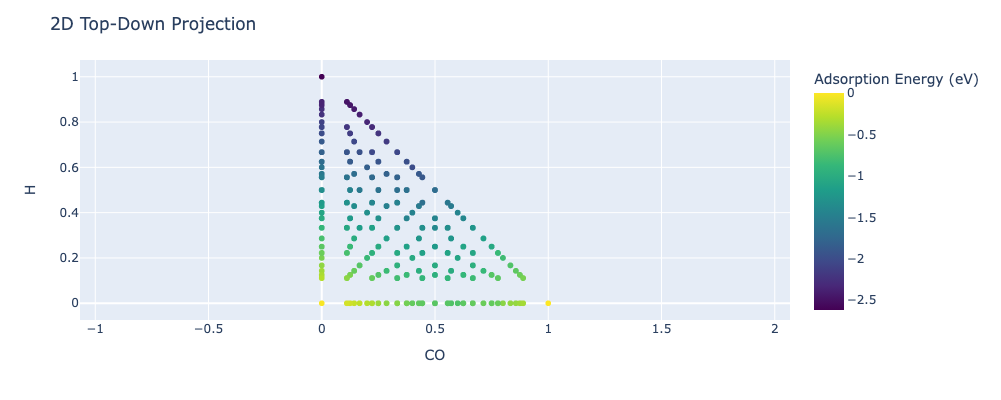

In [9]:
import plotly.express as px
import numpy as np


# Create a 2D scatter plot with color representing the z values
fig = px.scatter(x=x, y=y, color=z, color_continuous_scale='Viridis')

# Update layout for better visualization
fig.update_layout(
    title='2D Top-Down Projection',
    xaxis_title='CO',
    yaxis_title='H',
    coloraxis_colorbar=dict(title='Adsorption Energy (eV)'),
    xaxis=dict(scaleanchor="y", scaleratio=1),
    yaxis=dict(scaleanchor="x", scaleratio=1),
    width=600,  # Set the width of the canvas
    height=400,  # Set the height of the canvas
)

fig.show()


In [19]:
covs = list(chs.keys())
co_cov = set(sorted([c[0] for c in covs]))
h_cov = set(sorted([c[1] for c in covs]))
energies = []
for i in h_cov:
    es = []
    for j in co_cov:
        if (j,i) not in covs:
            es.append(None)
        else:
            es.append(chs[(j,i)][0])
    energies.append(es)

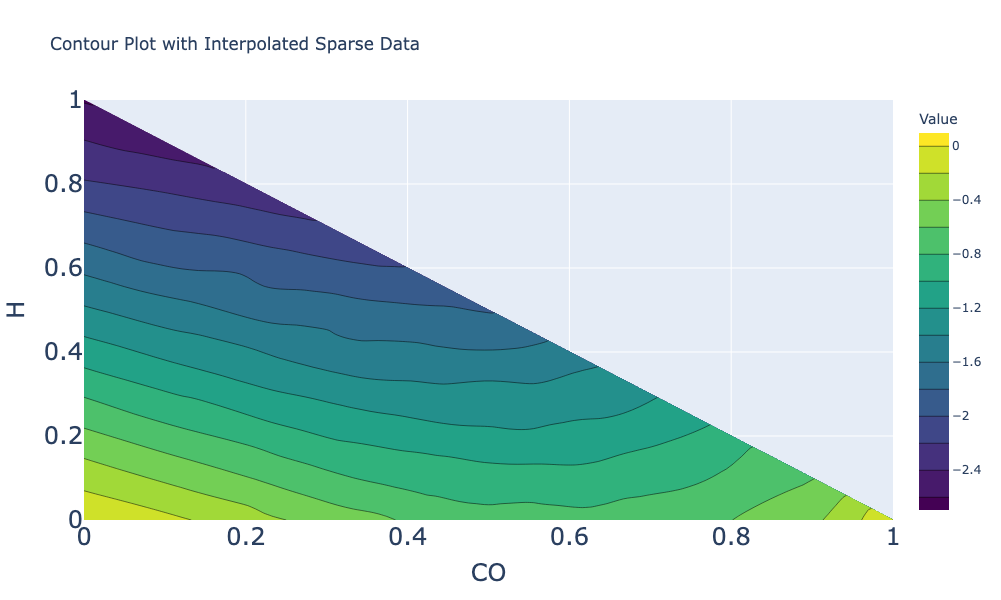

In [23]:
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import griddata

points = sorted(points, key=lambda x: x[0])
points = sorted(points, key=lambda x: x[1])
# Example sparse data
x_sparse = np.array([p[1] for p in points])
y_sparse = np.array([p[0] for p in points])
z_sparse = np.array([p[2] for p in points])

# Create a grid for interpolation
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:100j]

# Interpolate the sparse data to fill the grid
grid_z = griddata((x_sparse, y_sparse), z_sparse, (grid_x, grid_y), method='cubic')

# Create the contour plot
fig = go.Figure(go.Contour(
    z=grid_z,
    x=np.linspace(0, 1, 100),
    y=np.linspace(0, 1, 100),
    colorscale='Viridis',
    colorbar=dict(title='Value')
))

# Update layout for better visualization
fig.update_layout(
    title='Contour Plot with Interpolated Sparse Data',
    width=800,  # Set the width of the figure
    height=600,
    xaxis=dict(
        title="CO",
        title_font=dict(size=24),  # X-axis title font size
        tickfont=dict(size=24)  # X-axis tick label font size
    ),
    yaxis=dict(
        title="H",
        title_font=dict(size=24),  # X-axis title font size
        tickfont=dict(size=24)  # X-axis tick label font size
    )
)

fig.show()


In [ ]:
from caxpert.src.tasks.inference import mk_inf_db, MLInfDataProcess
from ase.calculators.espresso import Espresso
from caxpert.src.tasks.run_dft import ml_val
import os

# mk_inf_db('init_structures.db','ft/ml_inf', 'ft/ml_inf.db')
mp = MLInfDataProcess('ft/ml_inf.db', ['co', 'h'], 'Ni', 4)
# mp.plot_energy(output_fig='ft/ml_inf.html')
# chs = mp.get_convex_hull()

# write your own code to choose the structures you want to use for validation and retrain the model
# h_only = mp.get_structures_to_validate([[0,0], [0.1,1]],10, cov_must_have=[(float(0), float(1))])
# co_only = mp.get_structures_to_validate([[0.1,1], [0,0]],10, cov_must_have=[(float(1), float(0))])
h_co = mp.get_structures_to_validate([[0.3,1], [0.1,1]],10)
# ids_to_val = []
# for strs in [h_only, co_only, h_co]:
#     for v in strs.values():
#         ids_to_val.append(v[1])

# calculated_ids = [int(i) for i in os.listdir('dft_relax')]
# calculated_ids.extend([int(i) for i in os.listdir('dft_relax_h_only')])

# ids_to_val = [i for i in ids_to_val if i not in calculated_ids]

# espresso_settings = {
#     'control': {
#         'verbosity': 'high',
#         'calculation': 'scf',
#         'pseudo_dir': '/global/homes/x/xuchao/espresso/pseudo',
#         'disk_io': 'none'
#     },
#     'system': {
#         'input_dft': 'RPBE',
#         'occupations': 'smearing',
#         'smearing': 'mv',
#         'degauss': 0.01,
#         'ecutwfc': 40,
#         'nspin': 2,
#     },
#     'electrons': {
#         'electron_maxstep': 200,
#         'mixing_mode': 'local-TF',
#         'mixing_beta': 0.5,
#         'diagonalization': 'cg',
#     },
# }
# command = "srun pw.x -npool 1 -ndiag 1 -input espresso.pwi > espresso.pwo"
# pseudopotentials = {
#                         'Ni': 'Ni_ONCV_PBE-1.2.upf',
#                         'C': 'C_ONCV_PBE-1.2.upf',
#                         'O': 'O_ONCV_PBE-1.2.upf',
#                         'H': 'H_ONCV_PBE-1.2.upf',
#                         }
# kpts=(5, 5, 1)

# qe_calc = Espresso(
#                 command=command,
#                 pseudopotentials=pseudopotentials,
#                 tstress=True,
#                 tprnfor=True,
#                 kpts=kpts,
#                 input_data=espresso_settings,
#                 disk_io='none',
#                 )

# ml_val(ids_to_val, 'ft/ml_inf.db', qe_calc, 'ft/ml_inf_dft_val.db')


In [14]:
## Don't delete, for polynomial fitting of co and h
chs = mp.get_convex_hull()

In [15]:
X = np.array([list(k) for k in chs.keys()])
z = np.array([v[0] for v in chs.values()])

In [16]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Define the degree of the polynomial
degree = 3

# Create a pipeline with PolynomialFeatures and LinearRegression
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Fit the model
model.fit(X, z)

# Get the coefficients
coefficients = model.named_steps['linearregression'].coef_
intercept = model.named_steps['linearregression'].intercept_

print(f"Intercept: {intercept}")
print(f"Coefficients: {coefficients}")

# Use the model to predict z values
z_pred = model.predict(X)

# Evaluate the model (e.g., with R^2 score)
r_squared = model.score(X, z)
print(f"R^2 score: {r_squared}")

Intercept: 0.021817199054861458
Coefficients: [ 0.         -1.71578356 -2.88363344 -0.5263014   0.75464604  0.09301635
  2.13259418  1.03470505  0.07263712  0.13341342]
R^2 score: 0.999132605930077


In [36]:
a = [3,5,2,7,8]
with connect('test.db') as db:
    for i in a:
        index = db.reserve(original_id=i)
        

In [38]:
with connect('test.db') as db:
    for i in a:
        index = db.get(original_id=i)
        print(index.original_id)
        db.update(index.id, index.toatoms(), data=index.key_value_pairs)

3
5
2
7
8


## Check H only DFT data because the ML training is really bad

In [3]:
# This block finds all the trajs with only H atom on the surface
h_only_fs = []
for i in os.listdir('dft_relax_h_only'):
    h_only_fs.append(os.path.join(os.getcwd(), 'dft_relax_h_only', i, 'relax.traj'))

for i in os.listdir('relax_after_ml'):
    relax_after_ml_p = os.path.join(os.getcwd(), 'relax_after_ml', i, 'relax.traj')
    try:
        traj = Trajectory(relax_after_ml_p)[-1]
    except Exception as e:
        print(i, e)
        continue
    fmax = np.max(np.linalg.norm(traj.get_forces(), axis=1))
    if fmax > 0.05:
        continue
    if not any(traj.symbols == 'C'):
        h_only_fs.append(relax_after_ml_p)
        
# load slab db
slabs = {}
with connect('slabs.db') as db:
    for i in db.select():
        atoms = i.toatoms()
        slabs[atoms.cell.cellpar().tobytes()] = atoms

# load gas reference
gas = {}
with connect('gas_ref.db') as db:
    for i in db.select():
        atoms = i.toatoms()
        gas[atoms.symbols.get_chemical_formula()] = atoms
h_gas = gas['H'].get_potential_energy()

In [14]:
energies = []
covs = []
for i in h_only_fs:
    traj = Trajectory(i)[-1]
    adsorbate = traj.get_potential_energy()
    slab_energy = slabs[traj.cell.cellpar().tobytes()].get_potential_energy()
    h_num = traj.symbols.count('H')
    ni_num = traj.symbols.count('Ni')
    ads_energy = adsorbate - slab_energy - h_num * h_gas
    ads_avg = ads_energy/h_num
    # fmax = np.linalg.norm(traj.get_forces(), axis=1).max()
    energies.append(ads_avg)
    covs.append(h_num / (ni_num/4))

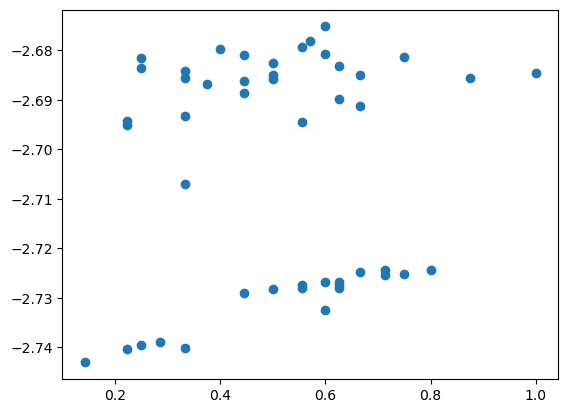

In [5]:
plt.scatter(covs, energies)

In [12]:
# check the DFT validation after ML
vals = []
with connect('ft/ml_inf_dft_val.db') as db:
    for i in db.select():
        vals.append(i.toatoms())
count = 1
for i in vals:
    print(count)
    count += 1
    print(i.symbols.get_chemical_formula())
    print(np.linalg.norm(i.get_forces(), axis=1).max())

1
H5Ni32
0.0784440143540202
2
H3Ni36
0.08941422674845938
3
H2Ni20
0.027775692503561107
4
H3Ni20
0.0559063622764824
5
H7Ni32
0.043232844057419825
6
H2Ni32
0.05051478398158365
7
H4Ni28
0.04406111771071275
8
HNi28
0.042793266052391046
9
H5Ni28
0.05027084386095173
10
H3Ni24
0.04604985515349294
11
HNi4
0.05420986036450115
12
C7Ni32O7
0.31796503453647834
13
CNi36O
0.45383241616663433
14
C4Ni32O4
0.12726155380336984
15
C4Ni20O4
0.22918573394922287
16
CNi12O
0.3206700354012453
17
C5Ni36O5
0.14151764930212107
18
C6Ni28O6
0.30328139589603825
19
C2Ni32O2
0.22184847919815998
20
C7Ni36O7
0.23618615966333759
21
C2Ni36O2
0.29138394939590606
22
CNi4O
0.31199568149767204
23
C5H2Ni36O5
0.15295578423280715
24
C2HNi20O2
0.08517914124027097
25
C6H3Ni36O6
0.7277645751942798
26
C4H2Ni28O4
0.18517513965293325
27
C4HNi24O4
0.17814964329395352
28
C5HNi24O5
1.1947040824087558
29
C5H2Ni32O5
0.1830414357035409
30
C6H2Ni32O6
0.5826108252968333
31
C2HNi24O2
0.2276158642669992
32
C5H2Ni28O5
0.8832273704294196
33
H2Ni

RuntimeError: Atoms object has no calculator.

In [15]:
# get the ids for H only that have not been calculated
calculated_ids = [int(f.split('/')[-2]) for f in h_only_fs]
h_only_ids = dict()
with connect('ft/ml_inf.db') as db:
    for atms in db.select():
        traj = atms.toatoms()
        if not 'C' in traj.symbols.get_chemical_formula() and 'H' in traj.symbols.get_chemical_formula():
            if atms.id not in calculated_ids:
                h_only_ids[atms.id] = traj

In [16]:
# randomly write 30 structures to the relax_after_ml dir
random_sample = random.sample(list(h_only_ids.keys()), 30)
for i in random_sample:
    os.makedirs(f'relax_after_ml/{i}', exist_ok=True)
    output_p = f'relax_after_ml/{i}/init.traj'
    atoms = h_only_ids[i]
    magnetic_moments = []
    for atom in atoms:
        if atom.symbol == 'Ni':
            magnetic_moments.append(10.8)
        elif atom.symbol == 'H':
            magnetic_moments.append(1.0)
        else:
            magnetic_moments.append(0.0)
    atoms.set_initial_magnetic_moments(magnetic_moments)
    write(output_p, atoms)

In [19]:
for i in os.listdir('relax_after_ml'):
    if len(os.listdir(f'relax_after_ml/{i}')) == 1:
        shutil.rmtree(f'relax_after_ml/{i}')

## Check the ML prediction and DFT for only H

In [14]:
def plot_one_sp_site(structures, ads_symbol, slab_symbol):
    """
    plot species with adsorption energy eV/site
    """
    cov = [traj.symbols.count(ads_symbol) / (traj.symbols.count(slab_symbol) / 4) for traj in structures]
    ads = [traj.get_potential_energy() / (traj.symbols.count(slab_symbol) / 4) for traj in structures]
    plt.scatter(cov, ads)
    plt.xlabel('Coverage of H')
    plt.ylabel('ML Adsorption Energy (eV/site)')
    plt.show()
    
def plot_one_sp_mol(structures, ads_symbol, slab_symbol):
    """
    plot species with adsorption energy eV/molecule
    """
    cov = [traj.symbols.count(ads_symbol) / (traj.symbols.count(slab_symbol) / 4) for traj in structures if traj.symbols.count(ads_symbol) !=0]
    ads = [traj.get_potential_energy() / traj.symbols.count(ads_symbol) for traj in structures if traj.symbols.count(ads_symbol) !=0]
    plt.scatter(cov, ads)
    plt.xlabel('Coverage of H')
    plt.ylabel('ML Adsorption Energy (eV/molecule)')
    plt.show()

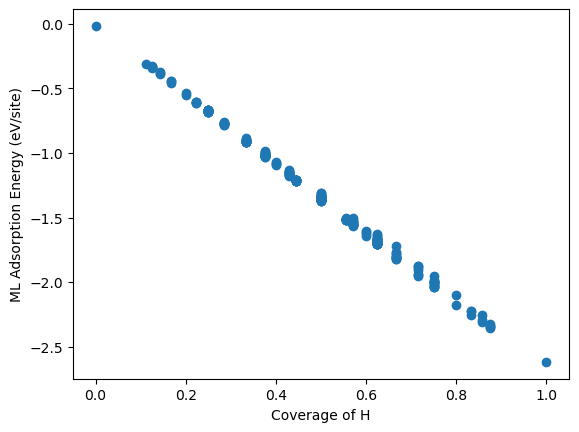

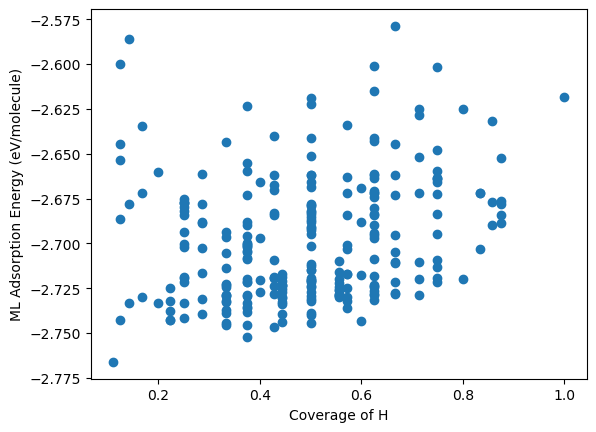

In [28]:
ml_db = connect('ft/ml_inf.db')
h_onlys = []
for atm in ml_db.select():
    struct = atm.toatoms()
    if 'C' not in struct.get_chemical_formula():
        h_onlys.append(struct)
plot_one_sp_site(h_onlys, 'H', 'Ni')
plot_one_sp_mol(h_onlys, 'H', 'Ni')

## Check the ML prediction and DFT for only CO

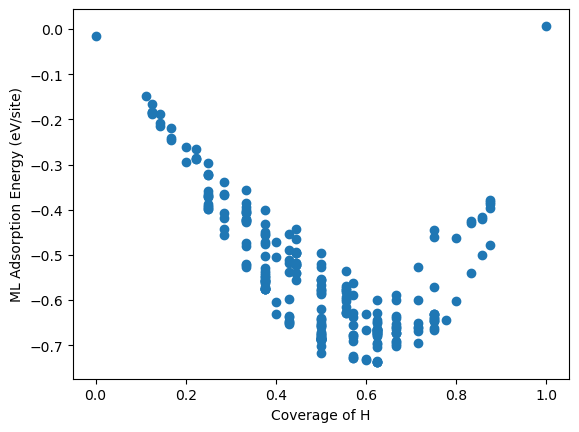

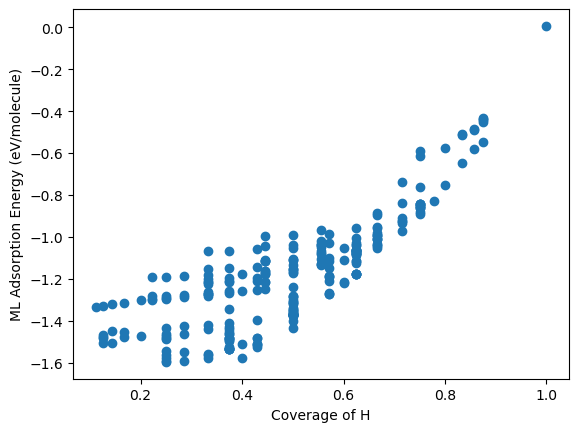

In [15]:
ml_db = connect('ft/ml_inf.db')
co_onlys = []
for atm in ml_db.select():
    struct = atm.toatoms()
    if 'H' not in struct.get_chemical_formula():
        co_onlys.append(struct)
plot_one_sp_site(co_onlys, 'C', 'Ni')
plot_one_sp_mol(co_onlys, 'C', 'Ni')